# Deep Learning Optical Flow Estimation
## DOT: Dense Optical Tracking (CVPR 2024)
## Tutorial Objectives
본 실습을 통해 다음과 같은 내용을 학습합니다:

1. **Dense Optical Tracking 알고리즘의 이론적 배경**을 이해
2. **DOT (Dense Optical Tracking) 모델의 주요 구성 요소**를 학습
3. **PointTracker와 OpticalFlow 클래스**의 핵심 함수들을 직접 구현
4. **Dense Optical Tracking**을 통한 비디오 분석
5. **실제 비디오 데이터**에서 tracking 결과를 시각화하고 분석

---

**Original Code**: https://github.com/16lemoing/dot

**Citation**
```
@inproceedings{lemoing2024dense,
  title = {Dense Optical Tracking: Connecting the Dots},
  author = {Le Moing, Guillaume and Ponce, Jean and Schmid, Cordelia},
  year = {2024},
  booktitle = {CVPR}
}
```

---


## 1. Overview

### 1.1 Dense Optical Tracking 소개

**Dense Optical Tracking**은 비디오의 모든 픽셀에 대해 temporal correspondence를 추정하는 기술입니다. 기존의 sparse tracking 방법과 달리, 이미지의 모든 픽셀에 대한 움직임을 추정하여 더욱 정확하고 세밀한 object tracking을 가능하게 합니다.

### 1.2 DOT (Dense Optical Tracking) Model

본 실습에서는 **DOT (Dense Optical Tracking) 모델**을 사용하여 고품질의 dense tracking을 구현합니다. DOT 모델은 다음과 같은 특징을 가집니다:

- **모든 픽셀에 대한 tracking**: 이미지의 모든 픽셀에 대해 움직임을 추정
- **고정밀도**: 기존 sparse tracking 대비 향상된 정확도
- **실시간 처리**: 효율적인 알고리즘으로 빠른 처리 속도 제공

## 2. Environment Setup

DOT 모델을 실행하기 위해서는 다음과 같은 과정이 필요합니다:
1. **Google Drive 마운트**: 데이터와 모델 저장을 위한 공간 확보
2. **DOT 모델 클론**: GitHub에서 공식 DOT 구현체 다운로드
3. **모델 가중치 다운로드**: 사전 훈련된 모델 체크포인트 준비
4. **의존성 라이브러리 설치**: 필요한 Python 패키지 설치

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 2.2 Clone DOT Repository

다음 단계는 DOT 모델의 공식 구현체를 GitHub에서 클론하는 것입니다. 이 repository에는 모델 구현, 사전 훈련된 가중치, 그리고 데모 코드가 포함되어 있습니다.


In [ ]:
!cd /content/drive/MyDrive && git clone https://github.com/snu-rvl/dot.git

### 2.3 Download Pre-trained Model Checkpoints

DOT 모델은 여러 종류의 사전 훈련된 체크포인트를 제공합니다:

- **movi_f_cotracker2_patch_4_wind_8.pth**: CoTracker2 기반 point tracking 모델
- **cvo_raft_patch_8.pth**: RAFT 기반 optical flow 모델
- **movi_f_raft_patch_4_alpha.pth**: 개선된 RAFT 모델

각각의 모델은 서로 다른 특성과 성능을 가지고 있으며, 용도에 따라 선택하여 사용할 수 있습니다.


In [ ]:
!cd /content/drive/MyDrive/dot && mkdir -p checkpoints \
&& cd checkpoints \
&& wget https://huggingface.co/16lemoing/dot/resolve/main/movi_f_cotracker2_patch_4_wind_8.pth \
&& wget https://huggingface.co/16lemoing/dot/resolve/main/cvo_raft_patch_8.pth \
&& wget https://huggingface.co/16lemoing/dot/resolve/main/movi_f_raft_patch_4_alpha.pth

### 2.4 Install Required Dependencies

DOT 모델 실행을 위해 필요한 라이브러리들을 설치합니다:

- **torch, torchvision**: PyTorch 딥러닝 프레임워크
- **tensorboard**: 학습 과정 모니터링 도구
- **tqdm**: 진행률 표시 라이브러리
- **matplotlib**: 결과 시각화를 위한 plotting 라이브러리
- **einops, einshape**: 텐서 연산 편의 라이브러리
- **scipy**: 과학 계산 라이브러리
- **timm**: 사전 훈련된 컴퓨터 비전 모델 라이브러리
- **lmdb**: 데이터베이스 관리
- **av, mediapy**: 비디오 처리 라이브러리


In [ ]:
! pip install torch==2.0.1 torchvision==0.15.2
! pip install tensorboard
! pip install tqdm matplotlib einops einshape scipy timm lmdb av mediapy
!pip uninstall -y numpy
!pip install numpy==1.26.4

### 2.5 Download Demo Dataset

실습에 사용할 데모 비디오 데이터셋을 다운로드합니다. 이 데이터셋에는 Dense Optical Tracking을 테스트할 수 있는 다양한 비디오 시퀀스가 포함되어 있습니다.


In [ ]:
!wget -P datasets https://huggingface.co/16lemoing/dot/resolve/main/demo.zip
!unzip datasets/demo.zip -d datasets/

## 3. Dense Optical Tracking Architecture

### 3.1 Overview of DOT Model

Dense Optical Tracking (DOT)은 비디오의 모든 픽셀에 대해 temporal correspondence를 추정하는 아키텍처입니다. 기존의 sparse tracking 방법과 달리, dense tracking은 전체 이미지에서 움직임을 추적하여 더욱 정확하고 완전한 motion field를 제공합니다.

### 3.2 Key Components

DOT 모델은 다음 세 가지 주요 구성 요소로 이루어져 있습니다:

1. **Initial Point Tracking**: CoTracker를 이용한 sparse한 포인트들의 초기 추적
   - Motion boundaries에서 중요한 포인트들을 선별하여 추적
   - 고품질의 초기 correspondence 제공

2. **Approximate Flow Field Initialization**: Nearest neighbor interpolation을 통한 dense flow 초기화
   - Sparse tracking 결과를 dense flow field로 확장
   - Visibility mask 함께 생성

3. **Optical Flow Refinement**: RAFT 기반 모델을 통한 flow field 정제
   - 초기 flow를 더욱 정확하게 개선
   - Occlusion handling 및 세밀한 motion 분석

### 3.3 RAFT vs DOT Architecture Differences

DOT은 기존 RAFT 모델과 다음과 같은 차이점을 가집니다:

- **첫 번째 convolution layer에서 stride=1 사용**: resolution이 p=4로 감소
- **Visibility mask 예측 추가**: 인코더 ε을 수정하고, 새로운 디코더 $D_M$ 추가
- **초기 flow field 활용**: CoTracker 결과를 바탕으로 한 warm start


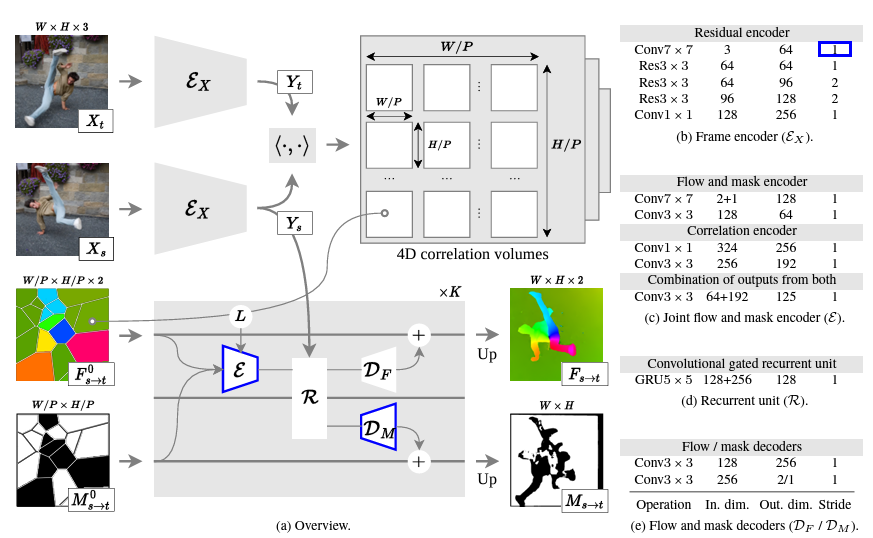


## 구성 요소
1. Initial point tracking (CoTracker 이용)
2. Initialization of approximate flow field and visibility mask(nearest neighbor interpolation 이용)
3. Optical flow refinement(RAFT 이용)

#### (참고) RAFT와 다른 점.
1. 첫번째 convolution layer에서 stride를 1로 사용해 resolution이 p=4로 감소
2. visibility mask도 함께 예측함. 인코더 ϵ을 수정하고, 새로운 modality를 고려하기 위해 새로운 디코더 $D_M$을 추가

## 4. Code Implementation


### 4.1 PointTracker 클래스 내부에 주요 함수 구현
#### 1) PointTracker 클래스 설명
get_tracks_at_motion_boundaries와 get_flow_from_last_to_first_frame이 두 가지 주요 작업을 합니다. 각각 다른 방식으로 비디오 내의 포인트들을 추적하고 다른 목적을 위해 데이터를 생성합니다.
- get_tracks_at_motion_boundaries: 비디오의 프레임 간의 motion boundaries를 추출하고, 해당 boundary 위의 point들을 추적하여 tracking 데이터를 생성합니다.
- get_flow_from_last_to_first_frame: 비디오의 마지막 프레임에서 첫 번째 프레임까지의 Optical Flow를 계산합니다. 이를 통해 비디오 내의 전체 움직임 경로를 파악할 수 있습니다.

#### 2) get_tracks_at_motion_boundaries
- 함수 인자 설명
  - data: dictionary 형태로, video라는 키가 있어 비디오 데이터를 담고 있습니다. 비디오는 텐서 형식으로 B, T, C, H, W 차원을 가집니다.
  - num_tracks: 추저할 총 포인트의 수를 의미합니다. 기본 값으로 8192를 가집니다.
  - sim_tracks: 샘플링하여 추적할 포인트의 수를 의미합니다. 기본 값으로 2048을 가집니다. 한 번에 추적할 포인트 수를 조절해서 연산의 효율성을 높일 수 있습니다.
  - sample_mode : 포인트를 샘플링할 모드를 지정합니다. all, first, last 중에 choice 가능합니다.

- TODO:
샘플링 모드에 따라 샘플링 방식을 주석을 참고하여 코드를 구현해보세요.

#### 3) get_flow_from_last_to_first_frame
- 함수 설명
비디오의 마지막 프레임에서 첫 번째 프레임으로의 optical flow나 tracking을 계산하는 역할을 합니다. 주어진 비디오를 시간 축을 따라 뒤집어, 마지막 프레임을 첫 번째 프레임으로 간주하여 계산을 진행합니다.

- 함수 인자 설명
  - data: dictionary 형태로, video라는 키가 있어 비디오 데이터를 담고 있습니다. 비디오는 텐서 형식으로 B, T, C, H, W 차원을 가집니다.
  - sim_tracks: 샘플링하여 추적할 포인트의 수를 의미합니다. 기본 값으로 2048을 가집니다. 한 번에 추적할 포인트 수를 조절해서 연산의 효율성을 높일 수 있습니다.

- TODO:
트랙킹을 위해 비디오 내의 특정 포인트를 샘플링하고, 모델이 포인트들의 트래킹 경로와 가시성(visibility)을 계산한 뒤, 이를 바탕으로 플로우 맵을 업데이트하는 방식을 사용합니다.
주석을 참고하여 코드를 구현해보세요.

In [ ]:
from tqdm import tqdm
import torch
from torch import nn

from drive.MyDrive.dot.dot.models.shelf import CoTracker, CoTracker2, Tapir
from drive.MyDrive.dot.dot.utils.io import read_config
from drive.MyDrive.dot.dot.utils.torch import sample_points, sample_mask_points, get_grid

class PointTracker(nn.Module):
    """
    PointTracker for tracking points and estimating optical flow in video sequences.

    Args:
        height: height of the input image
        width: width of the input image
        tracker_config: path to tracker config file
        tracker_path: path to tracker model weights
        estimator_config: path to optical flow estimator config file
        estimator_path: path to estimator weights
    """
    def __init__(self,  height, width, tracker_config, tracker_path, estimator_config, estimator_path):
        super().__init__()
        model_args = read_config(tracker_config)
        model_dict = {
            "cotracker": CoTracker,
            "cotracker2": CoTracker2,
            "tapir": Tapir,
            "bootstapir": Tapir
        }
        self.name = model_args.name
        self.model = model_dict[model_args.name](model_args)
        if tracker_path is not None:
            device = next(self.model.parameters()).device
            self.model.load_state_dict(torch.load(tracker_path, map_location=device), strict=False)
        self.optical_flow_estimator = OpticalFlow(height, width, estimator_config, estimator_path)

    def forward(self, data, mode, **kwargs):
        """
        Forward method for PointTracker.

        Args:
            data: input data dictionary (must include "video")
            mode: operation mode ("tracks_at_motion_boundaries" or "flow_from_last_to_first_frame")
            **kwargs: additional arguments

        Returns:
            Dictionary with tracking results or flow/visibility maps.
        """
        if mode == "tracks_at_motion_boundaries":
            return self.get_tracks_at_motion_boundaries(data, **kwargs)
        elif mode == "flow_from_last_to_first_frame":
            return self.get_flow_from_last_to_first_frame(data, **kwargs)
        else:
            raise ValueError(f"Unknown mode {mode}")

    def get_tracks_at_motion_boundaries(self, data, num_tracks=8192, sim_tracks=2048, sample_mode="all", **kwargs):
        """
        Track points at motion boundaries in a video sequence.

        Args:
            data: input data dictionary (must include "video")
            num_tracks: 총 추적할 포인트 개수
            sim_tracks: 한 번에 샘플링할 포인트 개수
            sample_mode: 포인트 샘플링 방식 ("all", "first", "last")
            **kwargs: optical flow 추정 추가 인자

        Returns:
            Dictionary with key "tracks": (B, T, N, 3) (좌표+가시성)
        """
        video = data["video"]
        N, S = num_tracks, sim_tracks
        B, T, _, H, W = video.shape
        assert N % S == 0

        # [TODO] 포인트 샘플링 방식에 따라 샘플 개수 및 설정 정하기
        '''
          "all" 모드: 모든 프레임에서 균등하게 포인트를 샘플링합니다.
          "first" 모드: 첫 번째 프레임에서만 포인트를 샘플링합니다.
          "last" 모드: 마지막 프레임에서만 포인트를 샘플링합니다.
        '''
        if sample_mode == "all":
            # 모든 프레임에서 고르게 샘플링 (2 lines)
            samples_per_step =
            samples_per_step[0] +=
            backward_tracking = True
            flip = False
        elif sample_mode == "first":
            # 첫 프레임에서만 샘플링
            # Implement here (2 lines)
            samples_per_step =
            samples_per_step[0] +=
            backward_tracking = False
            flip = False
        elif sample_mode == "last":
            # Implement here (2 lines)
            samples_per_step =
            samples_per_step[0] +=
            backward_tracking = False
            flip = True
        else:
            raise ValueError(f"Unknown sample mode {sample_mode}")

        # flip이 True면 temporal axis 뒤집기
        if flip:
            video = video.flip(dims=[1])

        # 여러 배치로 포인트 추적
        tracks = []
        motion_boundaries = {}
        cache_features = True
        for _ in tqdm(range(N // S), desc="Track batch of points", leave=False):
            src_points = []
            for src_step, src_samples in enumerate(samples_per_step):
                if src_samples == 0:
                    continue
                # 아직 motion boundary 계산 안 했으면 optical flow 추정
                if not src_step in motion_boundaries:
                    tgt_step = src_step - 1 if src_step > 0 else src_step + 1
                    data = {"src_frame": video[:, src_step], "tgt_frame": video[:, tgt_step]}
                    pred = self.optical_flow_estimator(data, mode="motion_boundaries", **kwargs)
                    motion_boundaries[src_step] = pred["motion_boundaries"]
                src_boundaries = motion_boundaries[src_step]
                src_points.append(sample_points(src_step, src_boundaries, src_samples))
            # 여러 프레임에서 샘플링된 포인트 concat
            src_points = torch.cat(src_points, dim=1)
            # 모델에 입력하여 trajectory, visibility 예측
            traj, vis = self.model(video, src_points, backward_tracking, cache_features)
            # trajectory + visibility를 concat하여 저장
            tracks.append(torch.cat([traj, vis[..., None]], dim=-1))
            cache_features = False
        # 전체 배치 track 합치기
        tracks = torch.cat(tracks, dim=2)

        # temporal flip 했으면 다시 뒤집기
        if flip:
            tracks = tracks.flip(dims=[1])

        return {"tracks": tracks}

    def get_flow_from_last_to_first_frame(self, data, sim_tracks=2048, **kwargs):
        """
        Estimate dense optical flow and visibility from last to first frame.

        Args:
            data: input data dictionary (must include "video")
            sim_tracks: 한 번에 샘플링할 포인트 개수
            **kwargs: optical flow 추정 추가 인자

        Returns:
            Dictionary with keys:
                "flow": (B, H, W, 2) optical flow
                "alpha": (B, H, W) visibility map
        """
        video = data["video"]
        # temporal axis 뒤집기 (last to first)
        video = video.flip(dims=[1])
        src_step = 0  # temporal axis flip했으므로 첫 프레임이 src
        B, T, C, H, W = video.shape
        S = sim_tracks
        backward_tracking = False
        cache_features = True
        flow = get_grid(H, W, shape=[B]).cuda()   # 초기 flow map 생성
        flow[..., 0] = flow[..., 0] * (W - 1)
        flow[..., 1] = flow[..., 1] * (H - 1)
        alpha = torch.zeros(B, H, W).cuda()       # 가시성 맵(alpha) 초기화
        mask = torch.ones(H, W)                   # 마스크 전체 1로 초기화 (남은 위치)
        pbar = tqdm(total=H * W // S, desc="Track batch of points", leave=False)
        while torch.any(mask):
            # mask에서 S개 포인트 샘플링
            points, (i, j) = sample_mask_points(src_step, mask, S)
            idx = i * W + j
            points = points.cuda()[None].expand(B, -1, -1)

            traj, vis = self.model(video, points, backward_tracking, cache_features)
            traj = traj[:, -1]
            vis = vis[:, -1].float()

            # [TODO2] mask, flow map, visibility map(alpha) 업데이트
            '''
              Update mask:
              - 포인트들이 추적되었으므로, 마스크에서 포인트들을 0으로 바꿔주어야 합니다.
            '''
            mask = mask.view(-1)
            # Implement here [1 line]

            mask = mask.view(H, W)

            '''
              flow 업데이트:
              - 모델이 예측한 traj(좌표)에서 원래 grid 좌표를 빼서 flow를 갱신
            '''
            flow = flow.view(B, -1, 2)
            # Implement here [1 line]

            flow = flow.view(B, H, W, 2)

            '''
              alpha(visibility) 업데이트:
              - 모델이 예측한 vis(가시성) 값을 alpha에 해당 위치에 업데이트
            '''
            alpha = alpha.view(B, -1)
            # Implement here [1 line]

            alpha = alpha.view(B, H, W)

            cache_features = False
            pbar.update(1)
        pbar.close()
        return {"flow": flow, "alpha": alpha}

## 5. Implementation Practice

### 5.1 OpticalFlow Class Overview

`OpticalFlow` 클래스는 RAFT와 같은 모델을 사용하여 비디오 프레임 간의 움직임을 계산하고, 다양한 모드에 따라 여러 기능을 제공합니다. 이 클래스는 다음과 같은 주요 기능들을 포함합니다:

- **`get_flow_with_tracks_init`**: 초기화된 포인트에 대한 optical flow를 계산합니다. 추정된 coarse flow와 alpha 값을 기반으로 더 정밀한 optical flow를 계산하며, visibility map(alpha)도 함께 반환합니다.

- **`get_motion_boundaries`**: DOT 모델에서 주어진 source frame과 target frame 사이의 motion boundary를 계산하는 역할을 합니다. 두 프레임 간의 optical flow를 계산하고, sobel filter를 사용해 boundary를 찾은 후, motion boundaries와 flow 데이터를 반환합니다.

### 5.2 Implementation Tasks

본 실습에서는 다음 두 가지 주요 함수를 구현하게 됩니다:

#### [Task 1]: Interpolate Function for Flow Initialization
(`get_flow_with_tracks_init`에서 사용할 `interpolate` 함수 구현)

**함수 목적**: Source points와 target points 간의 correspondence를 바탕으로 optical flow를 초기화합니다.

**함수 매개변수**:
- `src_points`: Source point를 포함하는 텐서 (위치와 visibility 정보 포함)
- `tgt_points`: Target point를 포함하는 텐서 (위치와 visibility 정보 포함)  
- `grid`: Grid 좌표를 나타내는 텐서 (거리 계산에 사용)

**구현 목표**: 특정 그리드 상에서 가장 가까운 source point를 찾고, 대응하는 point의 움직임을 계산하여 flow map을 생성합니다.

#### [Task 2]: Motion Boundaries Detection (`get_motion_boundaries`)

**함수 목적**: Source frame과 target frame 사이의 motion boundary를 검출합니다.

**함수 매개변수**:
- `data`: Dictionary 형태로 src_frame과 tgt_frame을 포함
- `boundaries_size`: Boundary를 찾기 위한 필터의 크기
- `boundaries_dilation`: Boundary 팽창 정도
- `boundaries_thresh`: 최종 boundary 판단 임계값

**구현 목표**: Sobel filter를 적용하여 boundary를 감지하는 부분을 구현합니다.

**힌트**: `F.conv2d` 함수를 사용하세요. ([PyTorch Documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html))

### 5.3 Background: Sobel Filter

Sobel filter는 이미지에서 edge를 검출하는 대표적인 방법입니다:

- **Edge의 정의**: 이미지나 영상에서 픽셀의 값이 한쪽으로 급격히 변하는 부분
- **검출 원리**: 픽셀값의 변화율(미분)을 측정하여 변화율이 큰 픽셀을 edge로 판단
- **구현 방식**: 픽셀 단위의 미분이므로 Discrete differentiation과 derivative approximation을 통해 구현 (이미지 내의 미분을 하기 위해서 여러 미분 마스크가 개발이 되었고, 그 중 하나가 sobel filter)

본 실습에서는 `get_sobel_kernel` 함수를 통해 미리 구현된 sobel filter를 사용할 수 있습니다.


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

from drive.MyDrive.dot.dot.models.shelf import RAFT
from drive.MyDrive.dot.dot.utils.io import read_config
from drive.MyDrive.dot.dot.utils.torch import get_grid

import warnings
import torch

try:
    from dot.utils import torch3d
except ModuleNotFoundError:
    torch3d = None

if torch3d:
    TORCH3D_AVAILABLE = True
else:
    TORCH3D_AVAILABLE = False


def interpolate(src_points, tgt_points, grid, version="torch3d"):
    B, S, _ = src_points.shape
    H, W, _ = grid.shape

    # For each point in a regular grid, find indices of nearest visible source point
    grid = grid.view(1, H * W, 2).expand(B, -1, -1)  # B HW 2
    src_pos, src_alpha = src_points[..., :2], src_points[..., 2]
    if version == "torch" or (version == "torch3d" and not TORCH3D_AVAILABLE):
        if version == "torch3d":
            warnings.warn(
                "Torch3D is not available. For optimal speed and memory consumption, consider setting it up.",
                stacklevel=2,
            )

        # TODO: 가장 가까운 source point 찾기
        '''
        Step 1: 각 grid point와 source point 간의 거리 계산
        - grid와 src_pos 사이의 euclidean distance를 계산
        - torch.cdist() 함수를 사용하면 효율적으로 계산할 수 있음

        Step 2: 가시성이 없는 포인트 처리
        - src_alpha가 0인 포인트들은 보이지 않는 포인트들임
        - 이런 포인트들과의 거리를 무한대(float('inf'))로 설정함

        Step 3: 최근접 포인트 인덱스 찾기
        - torch.min()을 사용하여 가장 가까운 포인트의 인덱스 찾기
        - dim=2로 설정하여 source point 차원에서 최소값 찾기
        '''
        # Implement here [3 lines]
        dis =
        dis[src_alpha == 0] =
        _, idx =

        idx = idx.view(B, H * W, 1)
    elif version == "torch3d":
        src_pos_packed = src_pos[src_alpha.bool()]
        tgt_points_packed = tgt_points[src_alpha.bool()]
        lengths = src_alpha.sum(dim=1).long()
        max_length = int(lengths.max())
        cum_lengths = lengths.cumsum(dim=0)
        cum_lengths = torch.cat([torch.zeros_like(cum_lengths[:1]), cum_lengths[:-1]])
        src_pos = torch3d.packed_to_padded(src_pos_packed, cum_lengths, max_length)
        tgt_points = torch3d.packed_to_padded(tgt_points_packed, cum_lengths, max_length)
        _, idx, _ = torch3d.knn_points(grid, src_pos, lengths2=lengths, return_nn=False)
        idx = idx.view(B, H * W, 1)

    # Use correspondences between source and target points to initialize the flow
    # TODO: source point와 target point 간의 flow 초기화
    '''
    Step 1: target point와 source point 간의 flow 계산
    - tgt_points에서 src_points까지의 움직임 벡터를 계산
    - 이는 각 point가 어떻게 이동했는지를 나타냄

    Step 2: visibility 정보와 함께 결합
    - flow 정보와 visibility(alpha) 정보를 하나의 텐서로 결합
    - torch.cat()을 사용하여 [flow_x, flow_y, alpha] 형태로 만듦

    Step 3: nearest neighbor의 정보를 gather
    - torch.gather()를 사용하여 가장 가까운 source point의 정보를 가져옴
    - idx 인덱스를 사용하여 해당하는 flow 값들을 추출
    '''
    tgt_pos, tgt_alpha = tgt_points[..., :2], tgt_points[..., 2]
    # Implement here [3 line]
    flow =
    flow =
    flow =

    flow = flow.view(B, H, W, -1)
    flow, alpha = flow[..., :2], flow[..., 2]
    flow[..., 0] = flow[..., 0] * (W - 1)
    flow[..., 1] = flow[..., 1] * (H - 1)
    return flow, alpha

def get_sobel_kernel(kernel_size):
    K = kernel_size
    sobel = torch.tensor(list(range(K))) - K // 2
    sobel_x, sobel_y = sobel.view(-1, 1), sobel.view(1, -1)
    sum_xy = sobel_x ** 2 + sobel_y ** 2
    sum_xy[sum_xy == 0] = 1
    sobel_x, sobel_y = sobel_x / sum_xy, sobel_y / sum_xy
    sobel_kernel = torch.stack([sobel_x.unsqueeze(0), sobel_y.unsqueeze(0)], dim=0)
    return sobel_kernel

class OpticalFlow(nn.Module):
    def __init__(self, height, width, config, load_path):
        super().__init__()
        model_args = read_config(config)
        model_dict = {"raft": RAFT}
        self.model = model_dict[model_args.name](model_args)
        self.name = model_args.name
        if load_path is not None:
            device = next(self.model.parameters()).device
            self.model.load_state_dict(torch.load(load_path, map_location=device))
        coarse_height, coarse_width = height // model_args.patch_size, width // model_args.patch_size
        self.register_buffer("coarse_grid", get_grid(coarse_height, coarse_width))

    def forward(self, data, mode, **kwargs):
        if mode == "flow_with_tracks_init":
            return self.get_flow_with_tracks_init(data, **kwargs)
        elif mode == "motion_boundaries":
            return self.get_motion_boundaries(data, **kwargs)
        elif mode == "feats":
            return self.get_feats(data, **kwargs)
        elif mode == "tracks_for_queries":
            return self.get_tracks_for_queries(data, **kwargs)
        elif mode == "tracks_from_first_to_every_other_frame":
            return self.get_tracks_from_first_to_every_other_frame(data, **kwargs)
        elif mode == "flow_from_last_to_first_frame":
            return self.get_flow_from_last_to_first_frame(data, **kwargs)
        else:
            raise ValueError(f"Unknown mode {mode}")

    def get_motion_boundaries(self, data, boundaries_size=1, boundaries_dilation=4, boundaries_thresh=0.025, **kwargs):
        eps = 1e-12
        src_frame, tgt_frame = data["src_frame"], data["tgt_frame"]
        K = boundaries_size * 2 + 1
        D = boundaries_dilation
        B, _, H, W = src_frame.shape

        # padding
        reflect = torch.nn.ReflectionPad2d(K // 2)

        # sobel filter 생성
        sobel_kernel = get_sobel_kernel(K).to(src_frame.device)

        # optical flow 계산 후 정규화
        flow, _ = self.model(src_frame, tgt_frame)
        norm_flow = torch.stack([flow[..., 0] / (W - 1), flow[..., 1] / (H - 1)], dim=-1)
        norm_flow = norm_flow.permute(0, 3, 1, 2).reshape(-1, 1, H, W)

        # [TODO1] boundary 찾기
        '''
          1) norm_flow (shape: 2, 1, H, W) 를 reflect를 통해 padding 진행
          2) sobel kernel과 F.conv2d를 사용해서 2D convolution 연산을 수행
          3) boundary의 제곱합을 구한 후, 제곱근을 하여 boundary의 강도를 얻음
          4) boundary의 강도를 평균화, x,y 방향에서의 boundary 강도를 평균을 내어 최종적인 boundaries를 얻음
        '''
        # Implement here [3 lines]
        boundaries =
        boundaries =
        boundaries =

        if boundaries_dilation > 1:
            boundaries = torch.nn.functional.max_pool2d(boundaries, kernel_size=D * 2, stride=1, padding=D)
            boundaries = boundaries[:, :, -H:, -W:]
        boundaries = boundaries[:, 0]
        boundaries = boundaries - boundaries.reshape(B, -1).min(dim=1)[0].reshape(B, 1, 1)
        boundaries = boundaries / boundaries.reshape(B, -1).max(dim=1)[0].reshape(B, 1, 1)
        boundaries = boundaries > boundaries_thresh
        return {"motion_boundaries": boundaries, "flow": flow}

    def get_feats(self, data, **kwargs):
        video = data["video"]
        feats = []
        for step in tqdm(range(video.size(1)), desc="Extract feats for frame", leave=False):
            feats.append(self.model.encode(video[:, step]))
        feats = torch.stack(feats, dim=1)
        return {"feats": feats}

    def get_flow_with_tracks_init(self, data, is_train=False, interpolation_version="torch3d", alpha_thresh=0.8, **kwargs):
        coarse_flow, coarse_alpha = interpolate(data["src_points"], data["tgt_points"], self.coarse_grid,
                                                version=interpolation_version)
        flow, alpha = self.model(src_frame=data["src_frame"] if "src_feats" not in data else None,
                                 tgt_frame=data["tgt_frame"] if "tgt_feats" not in data else None,
                                 src_feats=data["src_feats"] if "src_feats" in data else None,
                                 tgt_feats=data["tgt_feats"] if "tgt_feats" in data else None,
                                 coarse_flow=coarse_flow,
                                 coarse_alpha=coarse_alpha,
                                 is_train=is_train)
        if not is_train:
            alpha = (alpha > alpha_thresh).float()
        return {"flow": flow, "alpha": alpha, "coarse_flow": coarse_flow, "coarse_alpha": coarse_alpha}

    def get_tracks_for_queries(self, data, **kwargs):
        raise NotImplementedError



## 6. DenseOpticalTracker 클래스 내부에서 활용하는 dense_to_sparse_tracks 함수 구현

### 1) 함수 설명
dense tracking 데이터를 sparse하게 변환해주는 함수입니다. 입력된 tracks 데이터를 그리드 샘플링을 통해 원하는 위치의 tracking 데이터로 변환하여 반환합니다.

### 2) 함수 인자 설명
- x: tracking point의 x좌표를 나타내는 텐서. [0, width-1] 범위 내의 값을 가짐.
- y: tracking point의 y좌표를 나타내는 텐서. [0, height-1] 범위 내의 값을 가짐.
- tracks: tracking 데이터, T, H, W, C의 형태를 가짐.
- height: 입력 데이터의 높이
- width: 입력 데이터의 너비

### 3) TODO:
그리드를 생성하고 정규화한 후, 샘플링을 수행합니다.그 후 트랙 데이터를 재배열하고 정규화를 진행합니다.
[hint]: 여러 library를 사용해서 구현해보세요.
- grid 생성: torch.stack(https://pytorch.org/docs/stable/generated/torch.stack.html)
- grid 확장: einops의 repeat(https://einops.rocks/api/repeat/)
- track data 재배열: einops의 rearrange (https://einops.rocks/api/rearrange/)
- sampling: F.grid_sample(https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
from einops import rearrange, repeat

from drive.MyDrive.dot.dot.utils.torch import get_grid


class DenseOpticalTracker(nn.Module):
    def __init__(self,
                 height=512,
                 width=512,
                 tracker_config="configs/cotracker2_patch_4_wind_8.json",
                 tracker_path="checkpoints/movi_f_cotracker2_patch_4_wind_8.pth",
                 estimator_config="configs/raft_patch_8.json",
                 estimator_path="checkpoints/cvo_raft_patch_8.pth",
                 refiner_config="configs/raft_patch_4_alpha.json",
                 refiner_path="checkpoints/movi_f_raft_patch_4_alpha.pth"):
        super().__init__()
        self.point_tracker = PointTracker(height, width, tracker_config, tracker_path, estimator_config, estimator_path)
        self.optical_flow_refiner = OpticalFlow(height, width, refiner_config, refiner_path)
        self.name = self.point_tracker.name + "_" + self.optical_flow_refiner.name
        self.resolution = [height, width]

    def forward(self, data, mode, **kwargs):
        if mode == "flow_from_last_to_first_frame":
            return self.get_flow_from_last_to_first_frame(data, **kwargs)
        elif mode == "tracks_for_queries":
            return self.get_tracks_for_queries(data, **kwargs)
        elif mode == "tracks_from_first_to_every_other_frame":
            return self.get_tracks_from_first_to_every_other_frame(data, **kwargs)
        elif mode == "tracks_from_every_cell_in_every_frame":
            return self.get_tracks_from_every_cell_in_every_frame(data, **kwargs)
        else:
            raise ValueError(f"Unknown mode {mode}")

    def get_flow_from_last_to_first_frame(self, data, **kwargs):
        B, T, C, h, w = data["video"].shape
        init = self.point_tracker(data, mode="tracks_at_motion_boundaries", **kwargs)["tracks"]
        init = torch.stack([init[..., 0] / (w - 1), init[..., 1] / (h - 1), init[..., 2]], dim=-1)
        data = {
            "src_frame": data["video"][:, -1],
            "tgt_frame": data["video"][:, 0],
            "src_points": init[:, -1],
            "tgt_points": init[:, 0]
        }
        pred = self.optical_flow_refiner(data, mode="flow_with_tracks_init", **kwargs)
        pred["src_points"] = data["src_points"]
        pred["tgt_points"] = data["tgt_points"]
        return pred

    def get_tracks_for_queries(self, data, **kwargs):
        time_steps = data["video"].size(1)
        query_points = data["query_points"]
        video = data["video"]
        S = query_points.size(1)
        B, T, C, h, w = video.shape
        H, W = self.resolution

        init = self.point_tracker(data, mode="tracks_at_motion_boundaries", **kwargs)["tracks"]
        init = torch.stack([init[..., 0] / (w - 1), init[..., 1] / (h - 1), init[..., 2]], dim=-1)

        if h != H or w != W:
            video = video.reshape(B * T, C, h, w)
            video = F.interpolate(video, size=(H, W), mode="bilinear")
            video = video.reshape(B, T, C, H, W)

        feats = self.optical_flow_refiner({"video": video}, mode="feats", **kwargs)["feats"]

        grid = get_grid(H, W, device=video.device)
        src_steps = [int(v) for v in torch.unique(query_points[..., 0])]
        tracks = torch.zeros(B, T, S, 3, device=video.device)
        for src_step in tqdm(src_steps, desc="Refine source step", leave=False):
            src_points = init[:, src_step]
            src_feats = feats[:, src_step]
            tracks_from_src = []
            for tgt_step in tqdm(range(time_steps), desc="Refine target step", leave=False):
                if src_step == tgt_step:
                    flow = torch.zeros(B, H, W, 2, device=video.device)
                    alpha = torch.ones(B, H, W, device=video.device)
                else:
                    tgt_points = init[:, tgt_step]
                    tgt_feats = feats[:, tgt_step]
                    data = {
                        "src_feats": src_feats,
                        "tgt_feats": tgt_feats,
                        "src_points": src_points,
                        "tgt_points": tgt_points
                    }
                    pred = self.optical_flow_refiner(data, mode="flow_with_tracks_init", **kwargs)
                    flow, alpha = pred["flow"], pred["alpha"]
                    flow[..., 0] = flow[..., 0] / (W - 1)
                    flow[..., 1] = flow[..., 1] / (H - 1)
                tracks_from_src.append(torch.cat([flow + grid, alpha[..., None]], dim=-1))
            tracks_from_src = torch.stack(tracks_from_src, dim=1)
            for b in range(B):
                cur = query_points[b, :, 0] == src_step
                if torch.any(cur):
                    cur_points = query_points[b, cur]
                    cur_x = cur_points[..., 2] / (w - 1)
                    cur_y = cur_points[..., 1] / (h - 1)
                    cur_tracks = dense_to_sparse_tracks(cur_x, cur_y, tracks_from_src[b], h, w)
                    tracks[b, :, cur] = cur_tracks
        return {"tracks": tracks}

    def get_tracks_from_first_to_every_other_frame(self, data, **kwargs):
        video = data["video"]
        B, T, C, h, w = video.shape
        H, W = self.resolution

        if h != H or w != W:
            video = video.reshape(B * T, C, h, w)
            video = F.interpolate(video, size=(H, W), mode="bilinear")
            video = video.reshape(B, T, C, H, W)

        init = self.point_tracker(data, mode="tracks_at_motion_boundaries", **kwargs)["tracks"]
        init = torch.stack([init[..., 0] / (w - 1), init[..., 1] / (h - 1), init[..., 2]], dim=-1)

        grid = get_grid(H, W, device=video.device)
        grid[..., 0] *= (W - 1)
        grid[..., 1] *= (H - 1)
        src_step = 0
        src_points = init[:, src_step]
        src_frame = video[:, src_step]
        tracks = []
        for tgt_step in tqdm(range(T), desc="Refine target step", leave=False):
            if src_step == tgt_step:
                flow = torch.zeros(B, H, W, 2, device=video.device)
                alpha = torch.ones(B, H, W, device=video.device)
            else:
                tgt_points = init[:, tgt_step]
                tgt_frame = video[:, tgt_step]
                data = {
                    "src_frame": src_frame,
                    "tgt_frame": tgt_frame,
                    "src_points": src_points,
                    "tgt_points": tgt_points
                }
                pred = self.optical_flow_refiner(data, mode="flow_with_tracks_init", **kwargs)
                flow, alpha = pred["flow"], pred["alpha"]
            tracks.append(torch.cat([flow + grid, alpha[..., None]], dim=-1))
        tracks = torch.stack(tracks, dim=1)
        return {"tracks": tracks}

    def get_tracks_from_every_cell_in_every_frame(self, data, cell_size=1, cell_time_steps=20, **kwargs):
        video = data["video"]
        B, T, C, h, w = video.shape
        H, W = self.resolution
        ch, cw, ct = h // cell_size, w // cell_size, min(T, cell_time_steps)

        if h != H or w != W:
            video = video.reshape(B * T, C, h, w)
            video = F.interpolate(video, size=(H, W), mode="bilinear")
            video = video.reshape(B, T, C, H, W)

        init = self.point_tracker(data, mode="tracks_at_motion_boundaries", **kwargs)["tracks"]
        init = torch.stack([init[..., 0] / (w - 1), init[..., 1] / (h - 1), init[..., 2]], dim=-1)

        feats = self.optical_flow_refiner({"video": video}, mode="feats", **kwargs)["feats"]

        grid = get_grid(H, W, device=video.device)
        visited_cells = torch.zeros(B, T, ch, cw, device=video.device)
        src_steps = torch.linspace(0, T - 1, T // ct).long()
        tracks = [[] for _ in range(B)]
        for k, src_step in enumerate(tqdm(src_steps, desc="Refine source step", leave=False)):
            if visited_cells[:, src_step].all():
                continue
            src_points = init[:, src_step]
            src_feats = feats[:, src_step]
            tracks_from_src = []
            for tgt_step in tqdm(range(T), desc="Refine target step", leave=False):
                if src_step == tgt_step:
                    flow = torch.zeros(B, H, W, 2, device=video.device)
                    alpha = torch.ones(B, H, W, device=video.device)
                else:
                    tgt_points = init[:, tgt_step]
                    tgt_feats = feats[:, tgt_step]
                    data = {
                        "src_feats": src_feats,
                        "tgt_feats": tgt_feats,
                        "src_points": src_points,
                        "tgt_points": tgt_points
                    }
                    pred = self.optical_flow_refiner(data, mode="flow_with_tracks_init", **kwargs)
                    flow, alpha = pred["flow"], pred["alpha"]
                    flow[..., 0] = flow[..., 0] / (W - 1)
                    flow[..., 1] = flow[..., 1] / (H - 1)
                tracks_from_src.append(torch.cat([flow + grid, alpha[..., None]], dim=-1))
            tracks_from_src = torch.stack(tracks_from_src, dim=1)
            for b in range(B):
                src_cell = visited_cells[b, src_step]
                if src_cell.all():
                    continue
                cur_y, cur_x = (1 - src_cell).nonzero(as_tuple=True)
                cur_x = (cur_x + 0.5) / cw
                cur_y = (cur_y + 0.5) / ch
                cur_tracks = dense_to_sparse_tracks(cur_x, cur_y, tracks_from_src[b], h, w)
                visited_cells[b] = update_visited(visited_cells[b], cur_tracks, h, w, ch, cw)
                tracks[b].append(cur_tracks)
        tracks = [torch.cat(t, dim=1) for t in tracks]
        return {"tracks": tracks}

def dense_to_sparse_tracks(x, y, tracks, height, width):
    h, w = height, width
    T = tracks.size(0)

    # [TODO3] grid 생성 후 트랙 재배열, 그리드 샘플링
    '''
      x와 y를 합쳐서 그리드를 생성하고, [-1, 1] 범위로 정규화 -> torch.stack 이용 (https://pytorch.org/docs/stable/generated/torch.stack.html)
      시간 차원을 추가하여 그리드 확장 -> einops의 repeat 이용 (https://einops.rocks/api/repeat/)
    '''
    # Implement here [2 lines]
    grid =
    grid =

    '''
      시간, 높이, 너비, 채널 순의 track data를 시간, 채널, 높이, 너비 순으로 재배열 -> einops의 rearrange 이용 (https://einops.rocks/api/rearrange/)
    '''
    # Implement here [1 line]
    tracks =

    '''
      입력 track data에서 필요한 위치의 값을 sampling -> F.grid_sample(https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html)
    '''
    # Implement here [1 line]
    tracks =

    '''
      시간, 채널, 샘플 순의 track data를 시간, 샘플, 채널 순으로 재배열하고, 좌표 값을 원래 크기로
    '''
    # Implement here [3 lines]
    tracks =
    tracks[..., 0] =
    tracks[..., 1] =

    tracks[..., 2] = (tracks[..., 2] > 0).float()
    return tracks

def update_visited(visited_cells, tracks, height, width, cell_height, cell_width):
    T = tracks.size(0)
    h, w = height, width
    ch, cw = cell_height, cell_width
    for tgt_step in range(T):
        tgt_points = tracks[tgt_step]
        tgt_vis = tgt_points[:, 2]
        visited = tgt_points[tgt_vis.bool()]
        if len(visited) > 0:
            visited_x, visited_y = visited[:, 0], visited[:, 1]
            visited_x = (visited_x / (w - 1) * cw).floor().long()
            visited_y = (visited_y / (h - 1) * ch).floor().long()
            valid = (visited_x >= 0) & (visited_x < cw) & (visited_y >= 0) & (visited_y < ch)
            visited_x = visited_x[valid]
            visited_y = visited_y[valid]
            tgt_cell = visited_cells[tgt_step].view(-1)
            tgt_cell[visited_y * cw + visited_x] = 1.
            tgt_cell = tgt_cell.view_as(visited_cells[tgt_step])
            visited_cells[tgt_step] = tgt_cell
    return visited_cells

## 7. Visualization Tools

### 7.1 Visualizer Class Overview

본 섹션에서는 Dense Optical Tracking 결과를 시각화하기 위한 도구들을 제공합니다. `Visualizer` 클래스는 다음과 같은 주요 기능을 포함합니다:

### 7.2 Visualization Methods

#### 7.2.1 Overlay Visualization (`plot_overlay`)
- **기능**: 비디오 프레임에 tracking된 포인트를 rainbow 색상으로 overlay합니다
- **특징**:
  - 각 포인트의 temporal trajectory를 color-coded로 표시
  - Occlusion 영역에 대해 white stripe 추가 옵션 제공
  - Frame-by-frame tracking 결과의 직관적 시각화

#### 7.2.2 Spaghetti Visualization (`plot_spaghetti`)
- **기능**: 선택된 포인트들의 이동 경로를 "spaghetti" 효과(colorful lines)로 표현합니다
- **특징**:
  - 시간축을 따라 포인트들이 연속적인 선으로 연결
  - Temporal motion pattern의 애니메이션 효과
  - Long-term tracking trajectory의 전체적인 흐름 파악

### 7.3 Configuration Parameters

Visualizer는 다양한 설정 매개변수를 통해 시각화 결과를 조정할 수 있습니다:
- `overlay_factor`: Overlay 투명도 조절
- `spaghetti_radius`: Spaghetti line 두께
- `spaghetti_length`: Trajectory 길이 제한
- `spaghetti_grid`: Grid 간격 설정

In [ ]:
import os
import argparse
from PIL import Image
from glob import glob
import numpy as np
import json
import torch
import torchvision
from torch.nn import functional as F
import cv2
import av


def create_folder(path, verbose=False, exist_ok=True, safe=True):
    if os.path.exists(path) and not exist_ok:
        if not safe:
            raise OSError
        return False
    try:
        os.makedirs(path)
    except:
        if not safe:
            raise OSError
        return False
    if verbose:
        print(f"Created folder: {path}")
    return True


def read_video(path, start_step=0, time_steps=None, channels="first", exts=("jpg", "png"), resolution=None):
    if path.endswith(".mp4"):
        video = read_video_opencv(path, start_step, time_steps, channels, resolution)
    else:
        video = read_video_from_folder(path, start_step, time_steps, channels, resolution, exts)


    return video

def read_video_opencv(path, start_step=0, time_steps=None, channels="first", resolution=None):
    cap = cv2.VideoCapture(path)
    frames = []
    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx < start_step:
            frame_idx += 1
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame.astype(np.float32) / 255.0
        if resolution is not None:
            frame = cv2.resize(frame, (resolution[1], resolution[0]))
        frames.append(torch.from_numpy(frame).permute(2,0,1))
        frame_idx += 1
        # time_steps를 지정한 경우 해당 프레임수만 읽고 종료
        if time_steps is not None and len(frames) >= time_steps:
            break
    cap.release()
    if not frames:
        raise ValueError(f"No frames read from video: {path}")
    video = torch.stack(frames)
    if channels == "last":
        video = video.permute(0, 2, 3, 1)
    return video



def read_video_from_folder(path, start_step, time_steps, channels, resolution, exts):
    paths = []
    for ext in exts:
        paths += glob(os.path.join(path, f"*.{ext}"))
    paths = sorted(paths)
    if time_steps is None:
        time_steps = len(paths) - start_step
    video = []
    for step in range(start_step, start_step + time_steps):
        frame = read_frame(paths[step], resolution, channels)
        video.append(frame)
    video = torch.stack(video)
    return video


def read_frame(path, resolution=None, channels="first"):
    frame = Image.open(path).convert('RGB')
    frame = np.array(frame)
    frame = frame.astype(np.float32)
    frame = frame / 255
    frame = torch.from_numpy(frame)
    frame = frame.permute(2, 0, 1)
    if resolution is not None:
        frame = F.interpolate(frame[None], size=resolution, mode="bilinear")[0]
    if channels == "last":
        frame = frame.permute(1, 2, 0)
    return frame


def write_video(video, path, channels="first", zero_padded=True, ext="png", dtype="torch"):
    if dtype == "numpy":
        video = torch.from_numpy(video)
    if path.endswith(".mp4"):
        write_video_to_file(video, path, channels)
    else:
        write_video_to_folder(video, path, channels, zero_padded, ext)

def write_video_to_file(video, path, channels):
    create_folder(os.path.dirname(path))
    if channels == "first":
        video = video.permute(0, 2, 3, 1)  # (T, H, W, C)
    if video.dtype != torch.uint8:
        video = video.clamp(0, 1)
        video = (video * 255).round().to(torch.uint8)
    video = video.cpu().numpy()

    container = av.open(path, mode='w')
    stream = container.add_stream('h264', rate=24)
    stream.width = video.shape[2]
    stream.height = video.shape[1]
    stream.pix_fmt = 'yuv420p'

    for frame in video:
        f = av.VideoFrame.from_ndarray(frame, format='rgb24')
        for packet in stream.encode(f):
            container.mux(packet)
    # flush
    for packet in stream.encode():
        container.mux(packet)
    container.close()


def write_frame(frame, path, channels="first"):
    create_folder(os.path.dirname(path))
    frame = frame.cpu().numpy()
    if channels == "first":
        frame = np.transpose(frame, (1, 2, 0))
    if frame.dtype != np.uint8:
        frame = np.clip(np.round(frame * 255), 0, 255).astype(np.uint8)
    frame = Image.fromarray(frame)
    frame.save(path)


def write_video_to_folder(video, path, channels, zero_padded, ext):
    create_folder(path)
    time_steps = video.shape[0]
    for step in range(time_steps):
        pad = "0" * (len(str(time_steps)) - len(str(step))) if zero_padded else ""
        frame_path = os.path.join(path, f"{pad}{step}.{ext}")
        write_frame(video[step], frame_path, channels)


def read_tracks(path):
    return np.load(path)


def write_tracks(tracks, path):
    np.save(path, tracks)


def read_config(path):
    with open(path, 'r') as f:
        config = json.load(f)
    args = argparse.Namespace(**config)
    return args

In [ ]:
import torch
from torch import nn
import os.path as osp
from tqdm import tqdm
from matplotlib import colormaps
import numpy as np
import scipy
import math

# from drive.MyDrive.dot.dot.utils.io import create_folder, write_video, read_video, read_frame
from drive.MyDrive.dot.dot.utils.torch import to_device, get_grid


class Visualizer(nn.Module):
    def __init__(self, save_mode="video", result_path = "results", overlay_factor=0.75, spaghetti_radius=1.5,
                 spaghetti_length=40, spaghetti_grid=30, spaghetti_scale=2, spaghetti_every=10, spaghetti_dropout=0):
        super().__init__()
        self.save_mode = save_mode
        self.result_path = result_path
        self.overlay_factor = overlay_factor
        self.spaghetti_radius = spaghetti_radius
        self.spaghetti_length = spaghetti_length
        self.spaghetti_grid = spaghetti_grid
        self.spaghetti_scale = spaghetti_scale
        self.spaghetti_every = spaghetti_every
        self.spaghetti_dropout = spaghetti_dropout

    def forward(self, data, mode):
        if "overlay" in mode:
            video = self.plot_overlay(data, mode)
        elif "spaghetti" in mode:
            video = self.plot_spaghetti(data, mode)
        else:
            raise ValueError(f"Unknown mode {mode}")
        save_path = osp.join(self.result_path, mode) + ".mp4" if self.save_mode == "video" else ""
        write_video(video, save_path)

    def plot_overlay(self, data, mode):
        T, C, H, W = data["video"].shape
        mask = data["mask"] if "mask" in mode else torch.ones_like(data["mask"])
        tracks = data["tracks"]

        if tracks.ndim == 4:
            col = get_rainbow_colors(int(mask.sum())).cuda()
        else:
            col = get_rainbow_colors(tracks.size(1)).cuda()

        video = []
        for tgt_step in tqdm(range(T), leave=False, desc="Plot target frame"):
            tgt_frame = data["video"][tgt_step]
            tgt_frame = tgt_frame.permute(1, 2, 0)

            # Plot rainbow points
            tgt_pos = tracks[tgt_step, ..., :2]
            tgt_vis = tracks[tgt_step, ..., 2]
            if tracks.ndim == 4:
                tgt_pos = tgt_pos[mask]
                tgt_vis = tgt_vis[mask]
            rainbow, alpha = draw(tgt_pos, tgt_vis, col, H, W)

            # Plot rainbow points with white stripes in occluded regions
            if "stripes" in mode:
                rainbow_occ, alpha_occ = draw(tgt_pos, 1 - tgt_vis, col, H, W)
                stripes = torch.arange(H).view(-1, 1) + torch.arange(W).view(1, -1)
                stripes = stripes % 9 < 3
                rainbow_occ[stripes] = 1.
                rainbow = alpha * rainbow + (1 - alpha) * rainbow_occ
                alpha = alpha + (1 - alpha) * alpha_occ

            # Overlay rainbow points over target frame
            tgt_frame = self.overlay_factor * alpha * rainbow + (1 - self.overlay_factor * alpha) * tgt_frame

            # Convert from H W C to C H W
            tgt_frame = tgt_frame.permute(2, 0, 1)
            video.append(tgt_frame)
        video = torch.stack(video)
        return video

    def plot_spaghetti(self, data, mode):
        bg_color = 1.
        T, C, H, W = data["video"].shape
        G, S, R, L = self.spaghetti_grid, self.spaghetti_scale, self.spaghetti_radius, self.spaghetti_length
        D = self.spaghetti_dropout

        # Extract a grid of tracks
        mask = data["mask"] if "mask" in mode else torch.ones_like(data["mask"])
        mask = mask[G // 2:-G // 2 + 1:G, G // 2:-G // 2 + 1:G]
        tracks = data["tracks"]
        if tracks.ndim == 4:
            tracks = tracks[:, G // 2:-G // 2 + 1:G, G // 2:-G // 2 + 1:G]
            tracks = tracks[:, mask]
        elif D > 0:
            N = tracks.size(1)
            assert D < 1
            samples = np.sort(np.random.choice(N, int((1 - D) * N), replace=False))
            tracks = tracks[:, samples]
        col = get_rainbow_colors(tracks.size(1)).cuda()

        # Densify tracks over temporal axis
        tracks = spline_interpolation(tracks, length=L)

        video = []
        cur_frame = None
        cur_alpha = None
        grid = get_grid(H, W).cuda()
        grid[..., 0] *= (W - 1)
        grid[..., 1] *= (H - 1)
        for tgt_step in tqdm(range(T), leave=False, desc="Plot target frame"):
            for delta in range(L):
                # Plot rainbow points
                tgt_pos = tracks[tgt_step * L + delta, :, :2]
                tgt_vis = torch.ones_like(tgt_pos[..., 0])
                tgt_pos = project(tgt_pos, tgt_step * L + delta, T * L, H, W)
                tgt_col = col.clone()
                rainbow, alpha = draw(S * tgt_pos, tgt_vis, tgt_col, int(S * H), int(S * W), radius=R)
                rainbow, alpha = rainbow.cpu(), alpha.cpu()

                # Overlay rainbow points over previous points / frames
                if cur_frame is None:
                    cur_frame = rainbow
                    cur_alpha = alpha
                else:
                    cur_frame = alpha * rainbow + (1 - alpha) * cur_frame
                    cur_alpha = 1 - (1 - cur_alpha) * (1 - alpha)

                plot_first = "first" in mode and tgt_step == 0 and delta == 0
                plot_last = "last" in mode and delta == 0
                plot_every = "every" in mode and delta == 0 and tgt_step % self.spaghetti_every == 0
                if delta == 0:
                    if plot_first or plot_last or plot_every:
                        # Plot target frame
                        tgt_col = data["video"][tgt_step].permute(1, 2, 0).reshape(-1, 3)
                        tgt_pos = grid.view(-1, 2)
                        tgt_vis = torch.ones_like(tgt_pos[..., 0])
                        tgt_pos = project(tgt_pos, tgt_step * L + delta, T * L, H, W)
                        tgt_frame, alpha_frame = draw(S * tgt_pos, tgt_vis, tgt_col, int(S * H), int(S * W))
                        tgt_frame, alpha_frame = tgt_frame.cpu(), alpha_frame.cpu()

                        # Overlay target frame over previous points / frames
                        tgt_frame = alpha_frame * tgt_frame + (1 - alpha_frame) * cur_frame
                        alpha_frame = 1 - (1 - cur_alpha) * (1 - alpha_frame)

                        # Add last points on top
                        tgt_frame = alpha * rainbow + (1 - alpha) * tgt_frame
                        alpha_frame = 1 - (1 - alpha_frame) * (1 - alpha)

                        # Set background color
                        tgt_frame = alpha_frame * tgt_frame + (1 - alpha_frame) * torch.ones_like(tgt_frame) * bg_color

                        if plot_first or plot_every:
                            cur_frame = tgt_frame
                            cur_alpha = alpha_frame
                    else:
                        tgt_frame = cur_alpha * cur_frame + (1 - cur_alpha) * torch.ones_like(cur_frame) * bg_color

                    # Convert from H W C to C H W
                    tgt_frame = tgt_frame.permute(2, 0, 1)

                    # Translate everything to make the target frame look static
                    if "static" in mode:
                        end_pos = project(torch.tensor([[0, 0]]), T * L, T * L, H, W)[0]
                        cur_pos = project(torch.tensor([[0, 0]]), tgt_step * L + delta, T * L, H, W)[0]
                        delta_pos = S * (end_pos - cur_pos)
                        tgt_frame = translation(tgt_frame, delta_pos[0], delta_pos[1], bg_color)
                    video.append(tgt_frame)
        video = torch.stack(video)
        return video


def translation(frame, dx, dy, pad_value):
    C, H, W = frame.shape
    grid = get_grid(H, W, device=frame.device)
    grid[..., 0] = grid[..., 0] - (dx / (W - 1))
    grid[..., 1] = grid[..., 1] - (dy / (H - 1))
    frame = frame - pad_value
    frame = torch.nn.functional.grid_sample(frame[None], grid[None] * 2 - 1, mode='bilinear', align_corners=True)[0]
    frame = frame + pad_value
    return frame


def spline_interpolation(x, length=10):
    if length != 1:
        T, N, C = x.shape
        x = x.view(T, -1).cpu().numpy()
        original_time = np.arange(T)
        cs = scipy.interpolate.CubicSpline(original_time, x)
        new_time = np.linspace(original_time[0], original_time[-1], T * length)
        x = torch.from_numpy(cs(new_time)).view(-1, N, C).float().cuda()
    return x


def get_rainbow_colors(size):
    col_map = colormaps["jet"]
    col_range = np.array(range(size)) / (size - 1)
    col = torch.from_numpy(col_map(col_range)[..., :3]).float()
    col = col.view(-1, 3)
    return col


def draw(pos, vis, col, height, width, radius=1):
    H, W = height, width
    frame = torch.zeros(H * W, 4, device=pos.device)
    pos = pos[vis.bool()]
    col = col[vis.bool()]
    if radius > 1:
        pos, col = get_radius_neighbors(pos, col, radius)
    else:
        pos, col = get_cardinal_neighbors(pos, col)
    inbound = (pos[:, 0] >= 0) & (pos[:, 0] <= W - 1) & (pos[:, 1] >= 0) & (pos[:, 1] <= H - 1)
    pos = pos[inbound]
    col = col[inbound]
    pos = pos.round().long()
    idx = pos[:, 1] * W + pos[:, 0]
    idx = idx.view(-1, 1).expand(-1, 4)
    frame.scatter_add_(0, idx, col)
    frame = frame.view(H, W, 4)
    frame, alpha = frame[..., :3], frame[..., 3]
    nonzero = alpha > 0
    frame[nonzero] /= alpha[nonzero][..., None]
    alpha = nonzero[..., None].float()
    return frame, alpha


def get_cardinal_neighbors(pos, col, eps=0.01):
    pos_nw = torch.stack([pos[:, 0].floor(), pos[:, 1].floor()], dim=-1)
    pos_sw = torch.stack([pos[:, 0].floor(), pos[:, 1].floor() + 1], dim=-1)
    pos_ne = torch.stack([pos[:, 0].floor() + 1, pos[:, 1].floor()], dim=-1)
    pos_se = torch.stack([pos[:, 0].floor() + 1, pos[:, 1].floor() + 1], dim=-1)
    w_n = pos[:, 1].floor() + 1 - pos[:, 1] + eps
    w_s = pos[:, 1] - pos[:, 1].floor() + eps
    w_w = pos[:, 0].floor() + 1 - pos[:, 0] + eps
    w_e = pos[:, 0] - pos[:, 0].floor() + eps
    w_nw = (w_n * w_w)[:, None]
    w_sw = (w_s * w_w)[:, None]
    w_ne = (w_n * w_e)[:, None]
    w_se = (w_s * w_e)[:, None]
    col_nw = torch.cat([w_nw * col, w_nw], dim=-1)
    col_sw = torch.cat([w_sw * col, w_sw], dim=-1)
    col_ne = torch.cat([w_ne * col, w_ne], dim=-1)
    col_se = torch.cat([w_se * col, w_se], dim=-1)
    pos = torch.cat([pos_nw, pos_sw, pos_ne, pos_se], dim=0)
    col = torch.cat([col_nw, col_sw, col_ne, col_se], dim=0)
    return pos, col


def get_radius_neighbors(pos, col, radius):
    R = math.ceil(radius)
    center = torch.stack([pos[:, 0].round(), pos[:, 1].round()], dim=-1)
    nn = torch.arange(-R, R + 1)
    nn = torch.stack([nn[None, :].expand(2 * R + 1, -1), nn[:, None].expand(-1, 2 * R + 1)], dim=-1)
    nn = nn.view(-1, 2).cuda()
    in_radius = nn[:, 0] ** 2 + nn[:, 1] ** 2 <= radius ** 2
    nn = nn[in_radius]
    w = 1 - nn.pow(2).sum(-1).sqrt() / radius + 0.01
    w = w[None].expand(pos.size(0), -1).reshape(-1)
    pos = (center.view(-1, 1, 2) + nn.view(1, -1, 2)).view(-1, 2)
    col = col.view(-1, 1, 3).repeat(1, nn.size(0), 1)
    col = col.view(-1, 3)
    col = torch.cat([col * w[:, None], w[:, None]], dim=-1)
    return pos, col


def project(pos, t, time_steps, heigh, width):
    T, H, W = time_steps, heigh, width
    pos = torch.stack([pos[..., 0] / (W - 1), pos[..., 1] / (H - 1)], dim=-1)
    pos = pos - 0.5
    pos = pos * 0.25
    t = 1 - torch.ones_like(pos[..., :1]) * t / (T - 1)
    pos = torch.cat([pos, t], dim=-1)
    M = torch.tensor([
        [0.8, 0, 0.5],
        [-0.2, 1.0, 0.1],
        [0.0, 0.0, 0.0]
    ])
    pos = pos @ M.t().to(pos.device)
    pos = pos[..., :2]
    pos[..., 0] += 0.25
    pos[..., 1] += 0.45
    pos[..., 0] *= (W - 1)
    pos[..., 1] *= (H - 1)
    return pos


## 8. Practical Implementation and Demo

### 8.1 Main Function Overview

본 섹션에서는 Dense Optical Tracking 모델을 실제로 실행하고 결과를 시각화하는 전체 과정을 구현합니다. 실습의 최종 단계로서 모든 구성 요소들을 통합하여 완전한 tracking system을 구축합니다.

### 8.2 Configuration Parameters

다음 매개변수들을 통해 모델의 동작을 제어할 수 있습니다:

#### Model Configuration
- `args_height`, `args_width`: 입력 비디오의 해상도 설정
- `tracker_config/path`: CoTracker 모델 설정 및 체크포인트 경로
- `estimator_config/path`: RAFT 모델 설정 및 체크포인트 경로
- `refiner_config/path`: Refinement 모델 설정 및 체크포인트 경로

#### Visualization Settings
- `visualization_modes`: 시각화 방법 선택 (overlay, spaghetti 등)
- `rainbow_mode`: Color mapping 방향 설정
- `overlay_factor`: Overlay 투명도
- `spaghetti_*`: Spaghetti visualization 세부 설정

### 8.3 Execution Workflow

1. **Model Initialization**: 설정된 매개변수로 DenseOpticalTracker 모델 생성
2. **Data Loading**: 비디오 파일 로드 및 전처리
3. **Tracking Execution**: Dense Optical Tracking 수행
4. **Visualization**: 결과를 다양한 방식으로 시각화
5. **Output Generation**: 최종 결과 비디오/이미지 저장

In [ ]:
args_height = 512
args_width= 512
args_tracker_config = "/content/drive/MyDrive/dot/configs/cotracker2_patch_4_wind_8.json"
args_tracker_path = "/content/drive/MyDrive/dot/checkpoints/movi_f_cotracker2_patch_4_wind_8.pth"
args_estimator_config = "/content/drive/MyDrive/dot/configs/raft_patch_8.json"
args_estimator_path = "/content/drive/MyDrive/dot/checkpoints/cvo_raft_patch_8.pth"
args_refiner_config = "/content/drive/MyDrive/dot/configs/raft_patch_4_alpha.json"
args_refiner_path = "/content/drive/MyDrive/dot/checkpoints/movi_f_raft_patch_4_alpha.pth"
args_result_path = "results"
args_data_root = "datasets/demo"
args_video_path = "orange.mp4"         # 자유롭게 datasets/demo 내의 mp4 파일로 변경 가능
args_mask_path = "orange.png"          # video에 맞는 mask path 입력
args_recompute_tracks = False
args_save_tracks = False
args_inference_mode = "tracks_from_first_to_every_other_frame"
args_visualization_modes = ["overlay", "spaghetti_last_static"]
args_rainbow_mode = "left_right"  # choices=["left_right", "up_down"]
args_save_mode = "video"          # choices=["image", "video"]

args_overlay_factor = 0.75
args_spaghetti_radius = 1.5
args_spaghetti_length = 40
args_spaghetti_grid = 30
args_spaghetti_scale = 2
args_spaghetti_every = 10
args_spaghetti_dropout = 0


device = "cuda" if torch.cuda.is_available() else "cpu"

model = DenseOpticalTracker(height=args_height,
                            width=args_width,
                            tracker_config=args_tracker_config,
                            tracker_path=args_tracker_path,
                            estimator_config=args_estimator_config,
                            estimator_path=args_estimator_path,
                            refiner_config=args_refiner_config,
                            refiner_path=args_refiner_path,
                            ).to(device=device)

visualizer = Visualizer(save_mode=args_save_mode,
                        result_path = args_result_path,
                        overlay_factor=args_overlay_factor,
                        spaghetti_radius=args_spaghetti_radius,
                        spaghetti_length=args_spaghetti_length,
                        spaghetti_grid=args_spaghetti_grid,
                        spaghetti_scale=args_spaghetti_scale,
                        spaghetti_every=args_spaghetti_every,
                        spaghetti_dropout=args_spaghetti_dropout
                        ).to(device=device)

resolution = (args_height, args_width)

tracks_path = osp.join(args_result_path, "tracks.pth")
create_folder(args_result_path)

video = read_video(osp.join(args_data_root, args_video_path), resolution=resolution)
if isinstance(video, np.ndarray):
    video = torch.from_numpy(video)
video = video.to(device=device)


if not osp.exists(tracks_path) or args_recompute_tracks:
    with torch.no_grad():
        pred = model({"video": video[None]}, mode=args_inference_mode)
    tracks = pred["tracks"][0]
    if args_save_tracks:
        torch.save(tracks.cpu(), tracks_path)
else:
    tracks = torch.load(tracks_path)

mask_path = osp.join(args_data_root, args_mask_path)
if any(["mask" in mode] for mode in args_visualization_modes) and osp.exists(mask_path):
    mask = read_frame(mask_path, resolution=resolution)[0] > 0.5
else:
    mask = torch.ones(args_height, args_width).bool()

data = {
    "video": video,
    "tracks": tracks,
    "mask": mask
}

data = to_device(data, device)

if data["tracks"].ndim == 4 and args_rainbow_mode == "left_right":
    data["mask"] = data["mask"].permute(1, 0)
    data["tracks"] = data["tracks"].permute(0, 2, 1, 3)
elif data["tracks"].ndim == 3:
    points = data["tracks"][0]
    x, y = points[..., 0].long(), points[..., 1].long()
    x, y = x - x.min(), y - y.min()
    if args_rainbow_mode == "left_right":
        idx = y + x * y.max()
    else:
        idx = x + y * x.max()
    order = idx.argsort(dim=0)
    data["tracks"] = data["tracks"][:, order]

for mode in args_visualization_modes:
    visualizer(data, mode=mode)

## 9. Summary and Learning Outcomes

1. **Dense Optical Tracking의 이론적 기반**
   - Sparse tracking과 dense tracking의 차이점
   - CoTracker, RAFT, DOT 모델의 architecture 이해
   - Motion boundary detection과 visibility mask의 중요성

2. **실제 구현**
   - Point interpolation을 통한 flow field 초기화
   - Sobel filter를 이용한 motion boundary 검출
   - Grid sampling과 tensor manipulation 기술

3. **시각화 및 분석**
   - Overlay와 spaghetti visualization을 통한 결과 해석
   - Temporal trajectory pattern 분석
   - 실제 비디오 데이터에서의 tracking 성능 평가



In [ ]:
!pip install -q moviepy
import moviepy.editor
moviepy.editor.ipython_display("/content/results/spaghetti_last_static.mp4") # 자신의 결과 video path 입력